In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import calendar
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Optional: set matplotlib inline if using a Jupyter Notebook
%matplotlib inline

In [32]:
df = pd.read_csv('api_data/aggregated_measurements.csv')

df.set_index("Hour", inplace= True)
df.index = pd.to_datetime(df.index)

df['Total_consumption'] = df['Grid Organi lbc']

df = df.drop('Chargers achteraan', axis=1)
df = df.drop('Solar', axis=1)
df = df.drop('Chargers', axis=1)
df = df.drop('Grid Organi lbc', axis=1)

df

,Total_consumption
Hour,
2022-09-28 12:00:00,9.0010
2022-09-28 13:00:00,20.3787
2022-09-28 14:00:00,20.5578
2022-09-28 15:00:00,19.3390
2022-09-28 16:00:00,18.7600
...,...
2025-02-19 08:00:00,71.7051
2025-02-19 09:00:00,130.2653
2025-02-19 10:00:00,119.1813


In [33]:
be_holidays = holidays.BE()  # Belgian holidays

df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['is_festive'] = df.index.to_series().apply(lambda x: 1 if x in be_holidays else 0)
df['working_hour'] = df['hour'].apply(lambda x: 1 if 8 <= x <= 18 else 0)
df['is_summer'] = df.index.month.isin([6, 7, 8]).astype(int)
df['is_winter'] = df.index.month.isin([12, 1, 2]).astype(int)


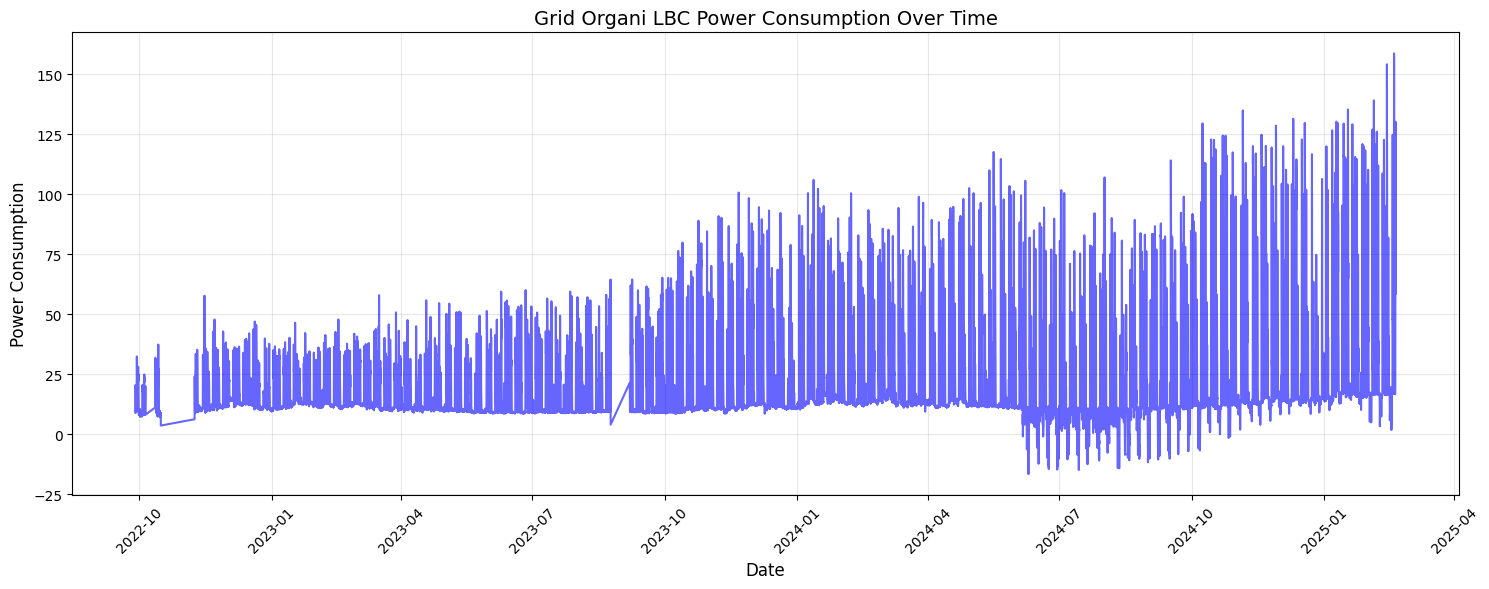


Basic Statistics:
count    19959.000000
mean        20.494159
std         18.626605
min        -16.521100
25%         10.834950
50%         13.089100
75%         22.813400
max        158.735000
Name: Grid Organi lbc, dtype: float64


In [28]:
# Create a figure with appropriate size
plt.figure(figsize=(15, 6))

# Plot the time series
plt.plot(df.index, df['Grid Organi lbc'], color='blue', alpha=0.6)

# Customize the plot
plt.title('Grid Organi LBC Power Consumption Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power Consumption', fontsize=12)
plt.grid(True, alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Optional: Show basic statistics
print("\nBasic Statistics:")
print(df['Grid Organi lbc'].describe())

In [44]:
# Create and fit the scaler
scaler = MinMaxScaler()
df['Total_consumption_normalized'] = scaler.fit_transform(df[['Total_consumption']])

target = "Total_consumption_normalized"

df

exog_features = [
    "hour",
    "day_of_week",
    "is_weekend",
    "is_festive",
    "working_hour",
    "is_summer",
    "is_winter"
]

y = df[target]
exog = df[exog_features]


In [45]:
split_index = int(0.80 * len(df))
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
exog_train, exog_test = exog.iloc[:split_index], exog.iloc[split_index:]

print(f"Training data from {df.index[0].date()} to {df.index[split_index-1].date()}")
print(f"Testing data from {df.index[split_index].date()} to {df.index[-1].date()}")

Training data from 2022-09-28 to 2024-09-06
Testing data from 2024-09-06 to 2025-02-19


In [46]:
model_auto = auto_arima(
    y_train,
    exogenous=exog_train,
    seasonal=False,       # Change to True and set m if seasonality exists
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)
print("Optimal ARIMA order:", model_auto.order)

order = model_auto.order  # e.g., (1, 1, 1)
model = SARIMAX(
    y_train,
    exog=exog_train,
    order=order,
    enforce_stationarity=False,
    enforce_invertibility=True
)
model_fit = model.fit(disp=False)

c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-60685.139, Time=7.96 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-56862.205, Time=0.58 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59353.498, Time=0.83 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-59487.588, Time=4.11 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-56864.205, Time=0.30 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-59483.595, Time=1.98 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-60971.861, Time=1.86 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-59610.987, Time=4.00 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-59827.596, Time=1.29 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-60715.923, Time=8.11 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-60228.188, Time=1.82 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-61266.540, Time=9.57 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-60260.314, Time=12.02 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-61324.830, Time=13.22 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-61279.522, Time=10.28 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-61360.277, Time=12.33 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=-61139.501, Time=13.15 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=-60753.846, Time=12.90 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-59843.306, Time=11.67 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-61452.927, Time=12.43 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-60256.354, Time=4.04 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-60252.598, Time=4.42 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[0]             : AIC=inf, Time=7.78 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0] intercept
Total fit time: 156.658 seconds
Optimal ARIMA order: (5, 1, 2)


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [47]:
y_pred = model_fit.forecast(steps=len(y_test), exog=exog_test)

def calculate_mape(y_true, y_pred):
    epsilon = 1e-10
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def calculate_smape(y_true, y_pred):
    denominator = np.abs(y_true) + np.abs(y_pred) + 1e-10
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / denominator)

def calculate_mase(y_true, y_pred, y_train):
    naive_errors = np.abs(np.diff(y_train))
    d = naive_errors.mean() if len(naive_errors) > 0 else 1e-10
    return np.mean(np.abs(y_true - y_pred)) / (d + 1e-10)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = calculate_mape(y_test.values, y_pred.values)
smape = calculate_smape(y_test.values, y_pred.values)
mase = calculate_mase(y_test.values, y_pred.values, y_train.values)

print(f"MAE:   {mae:.2f}")
print(f"MSE:   {mse:.2f}")
print(f"MAPE:  {mape:.2f}%")
print(f"sMAPE: {smape:.2f}%")
print(f"MASE:  {mase:.2f}")

MAE:   0.10
MSE:   0.03
MAPE:  27.18%
sMAPE: 33.58%
MASE:  5.09


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Predicted values have been saved to 'predicted_values_kwh.csv'.


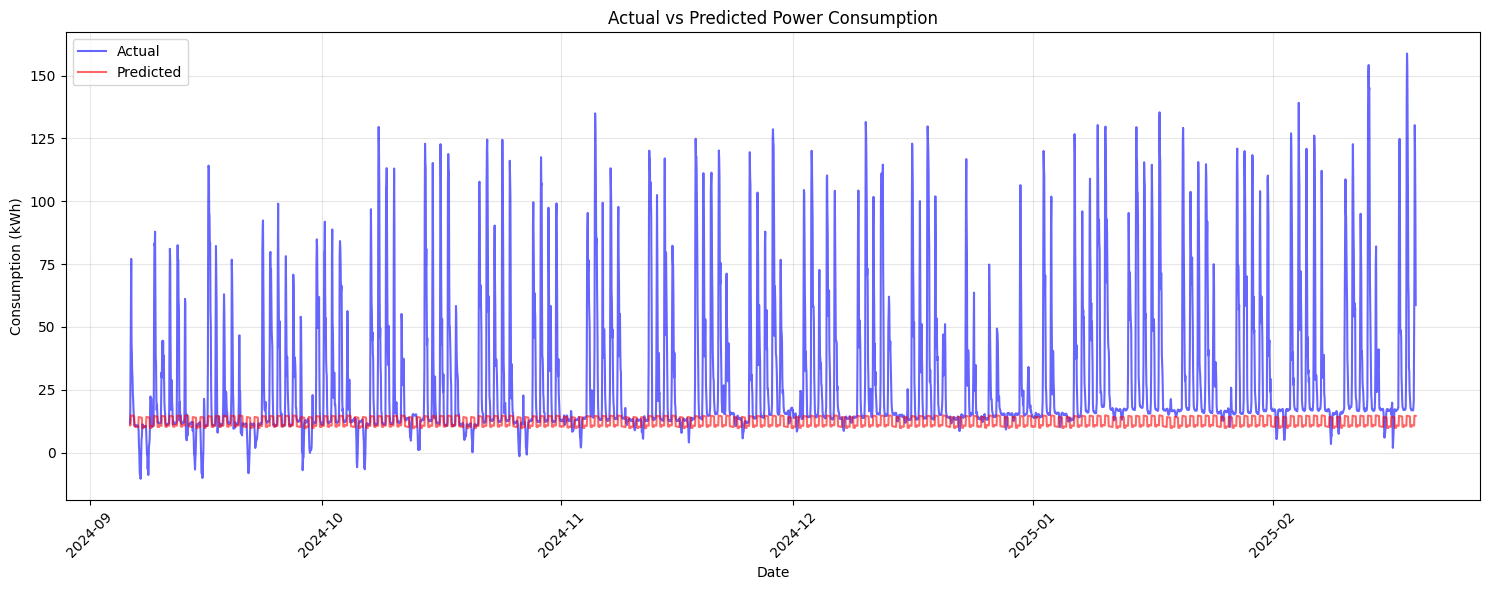

In [49]:
# ... existing code ...

y_pred_original = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()
y_test_original = scaler.inverse_transform(np.array(y_test).reshape(-1, 1)).flatten()

# Update the forecast DataFrame to use the original scale
forecast_df = pd.DataFrame({
    "Real_Consumption_kWh": y_test_original,
    "Predicted_Consumption_kWh": y_pred_original
}, index=y_test.index)

# Calculate the difference
forecast_df["Difference"] = forecast_df["Predicted_Consumption_kWh"] - forecast_df["Real_Consumption_kWh"]

# Round values to 4 decimal places
forecast_df = forecast_df.round(4)

# Save the predictions to a CSV file
forecast_df.to_csv("results/predicted_values_kwh.csv")
print("Predicted values have been saved to 'predicted_values_kwh.csv'.")

# Optional: Create a visualization of the predictions
plt.figure(figsize=(15, 6))
plt.plot(forecast_df.index, forecast_df["Real_Consumption_kWh"], label="Actual", color="blue", alpha=0.6)
plt.plot(forecast_df.index, forecast_df["Predicted_Consumption_kWh"], label="Predicted", color="red", alpha=0.6)
plt.title("Actual vs Predicted Power Consumption")
plt.xlabel("Date")
plt.ylabel("Consumption (kWh)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()